In [1]:
import msprime, tskit
import numpy as np
import plotly.graph_objects as go
from IPython.display import SVG

In [2]:
def example():
    node_times = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 0,
        8: 0,
        9: 0,
        10: 1,
        11: 2,
        12: 3,
        13: 4,
        14: 5,
        15: 6,
        16: 7,
        17: 8,
        18: 9,
        19: 10,
        20: 11,
        21: 12
    }
    # (p,c,l,r)
    edges = [
        (10,2,0,9),
        (10,5,0,9),
        (11,0,0,9),
        (11,7,0,9),
        (12,3,3,9),
        (12,9,3,9),
        (13,4,0,9),
        (13,11,0,9),
        (14,6,0,9),
        (14,10,0,9),
        (15,9,0,3),
        (15,13,0,3),
        (16,1,0,6),
        (16,3,0,3),
        (16,12,3,6),
        (17,1,6,9),
        (17,13,6,9),
        (18,13,3,6),
        (18,14,0,9),
        (18,15,0,3),
        (18,17,6,9),
        (19,8,0,9),
        (19,12,6,9),
        (19,16,0,6),
        (20,18,0,3),
        (20,18,6,9),
        (20,19,0,3),
        (20,19,6,9),
        (21,18,3,6),
        (21,19,3,6),
    ]
    samples = list(np.arange(10))
    tables = tskit.TableCollection(sequence_length=9)
    for (n,t,) in node_times.items():
        flags = tskit.NODE_IS_SAMPLE if n in samples else 0
        tables.nodes.add_row(time=t, flags=flags)
    for p, c, l, r in edges:
        tables.edges.add_row(parent=p, child=c, left=l, right=r)
    ts = tables.tree_sequence()
    return ts

In [3]:
def example2():
    node_times = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 1,
        5: 1,
        6: 4,
        7: 6,
        8: 10,
        9: 4,
        10: 12,
        11: 8,
        12: 8,
        13: 15
    }
    # (p,c,l,r)
    edges = [
        (4,0,0,9),
        (4,1,0,9),
        (5,2,0,6),
        (5,3,0,9),
        (6,4,0,3),
        (9,5,0,3),
        (7,4,3,6),
        (11,7,3,6),
        (12,5,3,6),
        (8,2,6,9),
        (8,4,6,9),
        (8,6,0,3),
        (10,5,6,9),
        (10,8,0,3),
        (10,8,6,9),
        (10,9,0,3),
        (10,11,3,6),
        (10,12,3,6),
        (13, 10, 3, 6)
    ]
    samples = list(np.arange(4))
    tables = tskit.TableCollection(sequence_length=9)
    for (n,t,) in node_times.items():
        flags = tskit.NODE_IS_SAMPLE if n in samples else 0
        tables.nodes.add_row(time=t, flags=flags)
    for p, c, l, r in edges:
        tables.edges.add_row(parent=p, child=c, left=l, right=r)
    ts = tables.tree_sequence()
    return ts

In [4]:
import typing
import dataclasses
FORWARD = 1
REVERSE = -1
@dataclasses.dataclass
class Interval:
    left: float
    right: float

    def __iter__(self):
        yield self.left
        yield self.right
@dataclasses.dataclass       
class EdgeRange:
    start: int
    stop: int
    order: typing.List

In [5]:
class TreePosition:
    def __init__(self, ts):
        self.ts = ts
        self.index = -1
        self.direction = 0
        self.interval = Interval(0, 0)
        self.in_range = EdgeRange(0, 0, None)
        self.out_range = EdgeRange(0, 0, None)

    def __str__(self):
        s = f"index: {self.index}\ninterval: {self.interval}\n"
        s += f"direction: {self.direction}\n"
        s += f"in_range: {self.in_range}\n"
        s += f"out_range: {self.out_range}\n"
        return s

    def assert_equal(self, other):
        assert self.index == other.index
        assert self.direction == other.direction
        assert self.interval == other.interval

    def set_null(self):
        self.index = -1
        self.interval.left = 0
        self.interval.right = 0

    def next(self):  # NOQA: A003
        M = self.ts.num_edges
        breakpoints = self.ts.breakpoints(as_array=True)
        left_coords = self.ts.edges_left
        left_order = self.ts.indexes_edge_insertion_order
        right_coords = self.ts.edges_right
        right_order = self.ts.indexes_edge_removal_order

        if self.index == -1:
            self.interval.right = 0
            self.out_range.stop = 0
            self.in_range.stop = 0
            self.direction = FORWARD

        if self.direction == FORWARD:
            left_current_index = self.in_range.stop
            right_current_index = self.out_range.stop
        else:
            left_current_index = self.out_range.stop + 1
            right_current_index = self.in_range.stop + 1

        left = self.interval.right

        j = right_current_index
        self.out_range.start = j
        while j < M and right_coords[right_order[j]] == left:
            j += 1
        self.out_range.stop = j
        self.out_range.order = right_order

        j = left_current_index
        self.in_range.start = j
        while j < M and left_coords[left_order[j]] == left:
            j += 1
        self.in_range.stop = j
        self.in_range.order = left_order

        self.direction = FORWARD
        self.index += 1
        if self.index == self.ts.num_trees:
            self.set_null()
        else:
            self.interval.left = left
            self.interval.right = breakpoints[self.index + 1]
        return self.index != -1

    def prev(self):
        M = self.ts.num_edges
        breakpoints = self.ts.breakpoints(as_array=True)
        right_coords = self.ts.edges_right
        right_order = self.ts.indexes_edge_removal_order
        left_coords = self.ts.edges_left
        left_order = self.ts.indexes_edge_insertion_order

        if self.index == -1:
            self.index = self.ts.num_trees
            self.interval.left = self.ts.sequence_length
            self.in_range.stop = M - 1
            self.out_range.stop = M - 1
            self.direction = REVERSE

        if self.direction == REVERSE:
            left_current_index = self.out_range.stop
            right_current_index = self.in_range.stop
        else:
            left_current_index = self.in_range.stop - 1
            right_current_index = self.out_range.stop - 1

        right = self.interval.left

        j = left_current_index
        self.out_range.start = j
        while j >= 0 and left_coords[left_order[j]] == right:
            j -= 1
        self.out_range.stop = j
        self.out_range.order = left_order

        j = right_current_index
        self.in_range.start = j
        while j >= 0 and right_coords[right_order[j]] == right:
            j -= 1
        self.in_range.stop = j
        self.in_range.order = right_order

        self.direction = REVERSE
        self.index -= 1
        if self.index == -1:
            self.set_null()
        else:
            self.interval.left = breakpoints[self.index]
            self.interval.right = right
        return self.index != -1

    def seek_forward(self, index):
        # NOTE this is still in development and not fully tested.
        assert index >= self.index and index < self.ts.num_trees
        M = self.ts.num_edges
        breakpoints = self.ts.breakpoints(as_array=True)
        left_coords = self.ts.edges_left
        left_order = self.ts.indexes_edge_insertion_order
        right_coords = self.ts.edges_right
        right_order = self.ts.indexes_edge_removal_order

        if self.index == -1:
            self.interval.right = 0
            self.out_range.stop = 0
            self.in_range.stop = 0
            self.direction = FORWARD

        if self.direction == FORWARD:
            left_current_index = self.in_range.stop
            right_current_index = self.out_range.stop
        else:
            left_current_index = self.out_range.stop + 1
            right_current_index = self.in_range.stop + 1

        self.direction = FORWARD
        left = breakpoints[index]

        # The range of edges we need consider for removal starts
        # at the current right index and ends at the first edge
        # where the right coordinate is equal to the new tree's
        # left coordinate.
        j = right_current_index
        self.out_range.start = j
        # TODO This could be done with binary search
        while j < M and right_coords[right_order[j]] <= left:
            j += 1
        self.out_range.stop = j

        if self.index == -1:
            # No edges, so out_range should be empty
            self.out_range.start = self.out_range.stop

        # The range of edges we need to consider for the new tree
        # must have right coordinate > left
        j = left_current_index
        while j < M and right_coords[left_order[j]] <= left:
            j += 1
        self.in_range.start = j
        # TODO this could be done with a binary search
        while j < M and left_coords[left_order[j]] <= left:
            j += 1
        self.in_range.stop = j

        self.interval.left = left
        self.interval.right = breakpoints[index + 1]
        self.out_range.order = right_order
        self.in_range.order = left_order
        self.index = index

    def seek_backward(self, index):
        # NOTE this is still in development and not fully tested.
        assert index >= 0
        M = self.ts.num_edges
        breakpoints = self.ts.breakpoints(as_array=True)
        left_coords = self.ts.edges_left
        left_order = self.ts.indexes_edge_insertion_order
        right_coords = self.ts.edges_right
        right_order = self.ts.indexes_edge_removal_order

        if self.index == -1:
            assert index < self.ts.num_trees
            self.index = self.ts.num_trees
            self.interval.left = self.ts.sequence_length
            self.in_range.stop = M - 1
            self.out_range.stop = M - 1
            self.direction = REVERSE
        else:
            assert index <= self.index

        if self.direction == REVERSE:
            left_current_index = self.out_range.stop
            right_current_index = self.in_range.stop
        else:
            left_current_index = self.in_range.stop - 1
            right_current_index = self.out_range.stop - 1

        self.direction = REVERSE
        right = breakpoints[index + 1]

        # The range of edges we need consider for removal starts
        # at the current left index and ends at the first edge
        # where the left coordinate is equal to the new tree's
        # right coordinate.
        j = left_current_index
        self.out_range.start = j
        # TODO This could be done with binary search
        while j >= 0 and left_coords[left_order[j]] >= right:
            j -= 1
        self.out_range.stop = j

        if self.index == self.ts.num_trees:
            # No edges, so out_range should be empty
            self.out_range.start = self.out_range.stop

        # The range of edges we need to consider for the new tree
        # must have left coordinate < right
        j = right_current_index
        while j >= 0 and left_coords[right_order[j]] >= right:
            j -= 1
        self.in_range.start = j
        # We stop at the first edge with right coordinate < right
        while j >= 0 and right_coords[right_order[j]] >= right:
            j -= 1
        self.in_range.stop = j

        self.interval.right = right
        self.interval.left = breakpoints[index]
        self.out_range.order = left_order
        self.in_range.order = right_order
        self.index = index

    def step(self, direction):
        if direction == FORWARD:
            return self.next()
        elif direction == REVERSE:
            return self.prev()
        else:
            raise ValueError("Direction must be FORWARD (+1) or REVERSE (-1)")

In [6]:
def _slide_mutation_nodes_up(ts, mutations):
    # adjusts mutations' nodes to place each mutation on the correct edge given
    # their time; requires mutation times be nonmissing and the mutation times
    # be >= their nodes' times.

    assert np.all(~tskit.is_unknown_time(mutations.time)), "times must be known"
    new_nodes = mutations.node.copy()

    mut = 0
    for tree in ts.trees():
        _, right = tree.interval
        while (
            mut < mutations.num_rows and ts.sites_position[mutations.site[mut]] < right
        ):
            t = mutations.time[mut]
            c = mutations.node[mut]
            p = tree.parent(c)
            assert ts.nodes_time[c] <= t
            while p != -1 and ts.nodes_time[p] <= t:
                c = p
                p = tree.parent(c)
            assert ts.nodes_time[c] <= t
            if p != -1:
                assert t < ts.nodes_time[p]
            new_nodes[mut] = c
            mut += 1

    # in C the node column can be edited in place
    new_mutations = mutations.copy()
    new_mutations.clear()
    for mut, n in zip(mutations, new_nodes):
        new_mutations.append(mut.replace(node=n))

    return new_mutations

In [194]:
def merge_edge_paths(edges_in, in_parent, out_parent, degree, not_sample, ts, edges):
    # We want a list (or dict) of all longest edge paths
    # from out tree and in tree
    paths = list()
    path_check = np.full(ts.num_nodes, False, dtype = bool)
    for ex_in in edges_in:
        e_in = ex_in[0]
        c = edges[e_in].child
        if path_check[c]:
            continue
        p_in = edges[e_in].parent
        p_out = out_parent[c]
        ipp = [c]
        opp = [c]
        if p_in != tskit.NULL:
            ipp.append(p_in)
        if p_out != tskit.NULL:
            opp.append(p_out)
        while p_out != tskit.NULL and degree[p_out] == 0 and not_sample[p_out]:
            opp.append(p_out)
            p_out = out_parent[p_out]
        if p_out != tskit.NULL:
            opp.append(p_out)
        while p_in != tskit.NULL and degree[p_in] < 3 and not_sample[p_in]:
            ipp.append(p_in)
            p_in = in_parent[p_in]
        if p_in != tskit.NULL:
            ipp.append(p_in)
        assert (-1 not in ipp) and (-1 not in opp)
        # build the path list:
        if (ipp[-1] == opp[-1]):
            path = list(set(ipp + opp))
            path.sort(key = lambda x: ts.tables.nodes.time[x])
            path_check[path[:-1]] = True
            paths.append(path)
            # print('out path', opp)
            # print('in path', ipp)
            # print('path', path)
        if (ipp[-1] != opp[-1]):
            common_nodes, ipp_ind, opp_ind = np.intersect1d(ipp, opp, return_indices = True)
            common_nodes, ipp_ind, opp_ind = list(common_nodes), list(ipp_ind), list(opp_ind)
            if len(common_nodes) > 1:
                common_nodes.sort(key = lambda x: ts.tables.nodes.time[x])
                oldest_node = common_nodes[-1]
                ipp_ind.sort(key = lambda x: ts.tables.nodes.time[ipp[x]])
                opp_ind.sort(key = lambda x: ts.tables.nodes.time[opp[x]])
                ipp_last_ind = ipp_ind[-1]
                opp_last_ind = opp_ind[-1]
                ipp = ipp[:ipp_last_ind+1]
                opp = opp[:opp_last_ind+1]
                path = list(set(ipp + opp))
                path.sort(key = lambda x: ts.tables.nodes.time[x])
                path_check[path[:-1]] = True
                paths.append(path)
                # print('out path', opp)
                # print('in path', ipp)
                # print('path', path)
    return paths

In [195]:
def _extend(ts, forwards=True):
    # `degree` will record the degree of each node in the tree we'd get if
    # we removed all `out` edges and added all `in` edges
    degree = np.full(ts.num_nodes, 0, dtype="int")
    # `out_parent` will record the sub-forest of edges-to-be-removed
    out_parent = np.full(ts.num_nodes, -1, dtype="int")
    # `in_parent` will record the sub-forest of edges-to-be-added
    in_parent = np.full(ts.num_nodes, -1, dtype="int")
    keep = np.full(ts.num_edges, True, dtype=bool)
    not_sample = [not n.is_sample() for n in ts.nodes()]
    nodes = ts.tables.nodes.copy()
    edges = ts.tables.edges.copy()
    node_times = ts.tables.nodes.time.copy()
    nodes_edge = np.full(ts.num_nodes, -1, dtype="int")
    # "here" will be left if fowards else right;
    # and "there" is the other
    new_left = edges.left.copy()
    new_right = edges.right.copy()
    if forwards:
        direction = 1
        # in C we can just modify these in place, but in
        # python they are (silently) immutable
        near_side = new_left
        far_side = new_right
    else:
        direction = -1
        near_side = new_right
        far_side = new_left
    edges_out = []
    edges_in = []

    tree_pos = TreePosition(ts)
    if forwards:
        valid = tree_pos.next()
    else:
        valid = tree_pos.prev()
    while valid:
        # print(f'--------{forwards}----------')
        left, right = tree_pos.interval
        here = left if forwards else right
        there = right if forwards else left
        nodes_edge = np.full(ts.num_nodes, -1, dtype="int")
        # Clear out non-extended or postponed edges:
        # Note: maintaining out_parent is a bit tricky, because
        # if an edge from p->c has been extended, entirely replacing
        # another edge from p'->c, then both edges may be in edges_out,
        # and we only want to include the *first* one.
        for e, _ in edges_out:
            out_parent[edges.child[e]] = -1
        tmp = []
        for e, x in edges_out:
            if x:
                tmp.append([e, False])
        edges_out = tmp
        tmp = []
        for e, x in edges_in:
            if x:
                tmp.append([e, False])
        edges_in = tmp

        for e, _ in edges_out:
            out_parent[edges.child[e]] = edges.parent[e]
        for e, _ in edges_in:
            in_parent[edges.child[e]] = edges.parent[e]

        for j in range(tree_pos.out_range.start, tree_pos.out_range.stop, direction):
            e = tree_pos.out_range.order[j]
            if out_parent[edges.child[e]] == -1:
                edges_out.append([e, False])
                out_parent[edges.child[e]] = edges.parent[e]

        for j in range(tree_pos.in_range.start, tree_pos.in_range.stop, direction):
            e = tree_pos.in_range.order[j]
            edges_in.append([e, False])
            in_parent[edges.child[e]] = edges.parent[e]
            nodes_edge[edges.child[e]] = e
            
        for e, _ in edges_out:
            degree[edges.parent[e]] -= 1
            degree[edges.child[e]] -= 1
            #print('Edges Out:: child', edges.child[e],'parent', edges.parent[e])
        for e, _ in edges_in:
            degree[edges.parent[e]] += 1
            degree[edges.child[e]] += 1

        # validate out_parent array
        for c, p in enumerate(out_parent):
            foundit = False
            for e, _ in edges_out:
                if edges.child[e] == c:
                    assert edges.parent[e] == p
                    foundit = True
                    break
            assert foundit == (p != -1)
        assert np.all(degree >= 0)
        added_edges = 0
        edge_paths = merge_edge_paths(edges_in, in_parent, out_parent, degree, not_sample, ts, edges)
        for path in edge_paths:
            for j in range(len(path)-1):
                child = path[j]
                new_parent = path[j+1]
                old_edge = nodes_edge[child]
                if old_edge != tskit.NULL:
                    old_parent = edges[old_edge].parent
                else:
                    old_parent = tskit.NULL
                if new_parent == old_parent:
                    # this is an edge already in the tree
                    # do nothing
                    # print('old edge', old_edge)
                    continue
                if new_parent != old_parent:
                    # check if our new edge is in edges_out 
                    # hence it should be extended
                    # find the edge
                    for ex_out in edges_out:
                        ex_out = ex_out
                        e_out = ex_out[0]
                        found_it = False
                        if edges[e_out].child == child and edges[e_out].parent == new_parent:
                            found_it = True
                            # print(child, new_parent, 'extend edge')
                            break
                    if found_it:
                        ex_out[1] = True
                        far_side[e_out] = there
                        if e_out != old_edge and old_edge != tskit.NULL:
                            near_side[old_edge] = there
                        nodes_edge[child] = e_out
                        # print(edges[e_out])
                        if degree[child] == 0:
                            degree[child] = 2
                        if degree[new_parent] == 0:
                            degree[new_parent] == 2
                    # if edge is not in edges_out
                    # it is new and should be added to 
                    # the edge table
                    if not found_it:
                        edges.add_row(parent = new_parent, child = child, left = left, right = right)
                        # print(child, new_parent, 'new edge')
                        # print(edges[-1])
                        added_edges += 1
                        if old_edge != tskit.NULL:
                            near_side[old_edge] = there
                        if forwards:
                            near_side = np.append(near_side, [left])
                            far_side = np.append(far_side, [right])
                            new_left = near_side
                            new_right = far_side
                        if not forwards:
                            near_side = np.append(near_side, [right])
                            far_side = np.append(far_side, [left])
                            new_left = far_side
                            new_right = near_side
                        if degree[new_parent] == 0:
                            degree[new_parent] = 2
                        if degree[new_parent] != 0:
                            degree[new_parent] += 1
                        if degree[child] == 0:
                            degree[child] = 2
        # Update keep
        if added_edges > 0:
            keep = np.concatenate([keep,np.full(added_edges, True, dtype = bool)]) # add as many as there are founds.
        assert len(keep) == edges.num_rows, print('keep', len(keep), 'num edges', edges.num_rows)
        # print(edges[keep])
        # print('near side', near_side)
        # print('far_side', far_side)
        # end of loop, next tree
        if forwards:
            valid = tree_pos.next()
        else:
            valid = tree_pos.prev()

    for j in range(edges.num_rows):
        left = new_left[j]
        right = new_right[j]
        if left < right:
            edges[j] = edges[j].replace(left=left, right=right)
        else:
            keep[j] = False
    edges.keep_rows(keep)
    return edges
    
def extend_edges(ts, max_iter=10):
    tables = ts.dump_tables()
    mutations = tables.mutations.copy()
    tables.mutations.clear()

    last_num_edges = ts.num_edges
    for _ in range(max_iter):
        for forwards in [True, False]:
            edges = _extend(ts, forwards=forwards)
            tables.edges.replace_with(edges)
            tables.sort()
            # print(tables.edges)
            tables.build_index()
            ts = tables.tree_sequence()
        if ts.num_edges == last_num_edges:
            break
        else:
            last_num_edges = ts.num_edges

    tables = ts.dump_tables()
    mutations = _slide_mutation_nodes_up(ts, mutations)
    tables.mutations.replace_with(mutations)
    ts = tables.tree_sequence()

    return ts

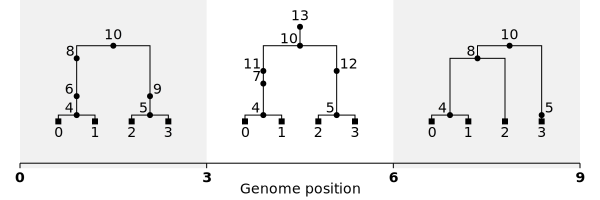

In [196]:
ex2 = example2()
SVG(ex2.draw_svg())

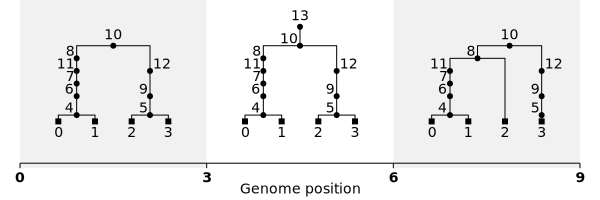

In [197]:
eex2 = extend_edges(ex2)
SVG(eex2.draw_svg())

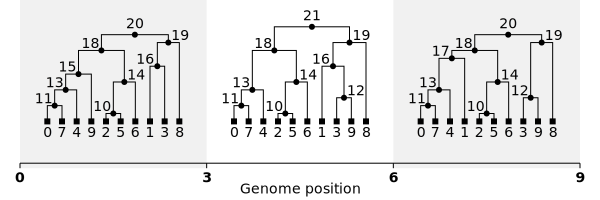

In [198]:
ex = example()
SVG(ex.draw_svg())

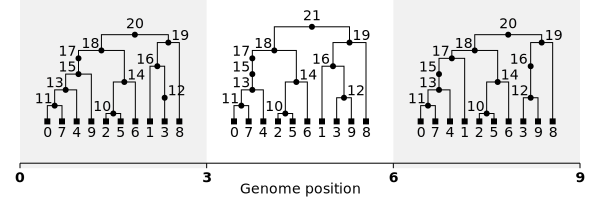

In [199]:
eex = extend_edges(ex)
SVG(eex.draw_svg())